In [34]:

import numpy as np
from scipy.signal import find_peaks
def initial_conditions_loop(ts: np.ndarray, #Array of time points, also determines step size of RK4 solver
                                light_est: np.ndarray, #Array of light estimates, should be the same length as ts
                                num_loops: int = 30) -> np.ndarray: 
        """ 
            Estimate the starting values by looping the given light_estimate, commonly used for to estimate the initial conditions
            assumes the individual lives the same schedule repeatedly
        """
        y = np.array([-0.3,-1.13,0.0])
#         y = np.array([x1,x2,0.0])
        for _ in range(num_loops):
            sol = integrate_model(ts, light_est, y)
            y = sol[..., -1]
        return y,sol

def integrate_model(ts: np.array,  # Array of time points, also determines step size of RK4 solver
                    light_est: np.array,  # Array of light estimates, should be the same length as ts
                    state: np.array,  # Initial state of the model
                    ):
    nloop = len(ts)
#     print("n: ",nloop)
    sol = np.zeros([state.shape[0], nloop])
    sol[..., 0] = state
#     print(sol[...,0])
    for idx in range(1, nloop):
        state = step_rk4(
        state=state,
        light_val=light_est[idx],
        dt=ts[idx]-ts[idx-1])
        sol[..., idx] = state
#     print("sol shape: ",sol.shape)
    return sol

def step_rk4(state: np.ndarray, #dy/dt = f(y, t)
              light_val: float, #light value at time t in lux
              dt=float #step size in hours
            ):
    k1 = derv(state, light=light_val)
    k2 = derv(state + k1 * dt / 2.0, light=light_val)
    k3 = derv(state + k2 * dt / 2.0, light=light_val)
    k4 = derv(state + k3 * dt, light=light_val)
    state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
    #   print("state: ",state)
    return state

def derv(y: np.array, #state vector (x, xc, n)
        light: float, #light value in lux
        ):

        taux = 24.2;
        G = 19.875;
        b = 0.013;
        k = .55;
        
        mu = .1300;
        q = 1.0/3;
        
        I0 = 9500;
        p = .6;
        a0 = 0.16;
        
        # Relational parameters to circadian markers
        phi_ref = 0.80; # relative to x min to get CBTmin, units of hours
        dlmo_convert = -7.0 #factor to convert from CBTmin to DLMO
        
        x =y[0]
        xc = y[1]
        n = y[2]
        #print("x: ",x," xc: ",xc, " n: ",n)
        
        alpha = a0*(light/I0)**p;
        Bh = G*alpha*(1-n);
        B = Bh*(1-0.4*x)*(1-0.4*xc);
               
        dydt = np.zeros_like(y)
        dydt[0] = np.pi/12* (xc + mu*(1/3*x+4/3*x**3-256/105*x**7) + B);
        dydt[1] = np.pi/12* (q*B*xc - x*((24/(0.99729*taux))**2 + k*B));
        dydt[2] = 60*(alpha*(1-n) - b*n);
        return dydt
    
def cbt(sol,ts):
        phi_ref = 0.8
        cbt_mins_test = find_peaks(-1*sol[0,:])[0]
        cbt_mins = find_peaks(-1*sol[0,:], distance =60 )[0] # min of x is the CBTmin
        # height condition so that peaks in the opposite direction are not considered, distance to ensure peaks are not chosen too close
        cbts = sol[0,:]
        return ts[cbt_mins] + phi_ref
    
def dlmos(sol,ts):
        dlmo_convert = -7
        return cbt(sol,ts) + dlmo_convert # dlmo is defines by a relationship to cbt for this model


In [35]:
'''
First 15 days: Sleep onset:- 2300, sleep end time:- 0500
First 15 days: Sleep onset:- 0300, sleep end time:- 0800
'''
import pandas as pd
import matplotlib.pyplot as plt
def ampval(k):



    # First 15 days
    num_days = 15
    # hourly_light = [k,k,k,k,k,k,k,k,0,0,0,0,0,0,0,k,k,k,k,k,k,k,k,k]
    hourly_light = [0,0,0,0,0,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,0]

    _df= []
    for i in range(num_days):
        _df.append([23.0,29.0,6.0])
    _df = pd.DataFrame(_df,columns=['start_time_num_round','end_time_num_round','sleep_duration_round'])   
    print("len of df: ", len(_df))

    light_values = []
    for hour in hourly_light:
        if hour == 0:
            j=0
            while j <4:
                light_values.append(0)
                j+=1
        else:
            j=0
            while j <4:
                light_values.append(k)
                j+=1
    light_values = light_values*num_days

    # Next 15 days
    num_days = 15
    # hourly_light = [0,0,0,0,0,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k]
    hourly_light = [k,k,k,0,0,0,0,0,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k]

    _df2= []
    for i in range(num_days):
        _df2.append([27.0,32.0,5.0])
    _df2 = pd.DataFrame(_df2,columns=['start_time_num_round','end_time_num_round','sleep_duration_round'])   
    print("len of df2: ", len(_df2))


    _df = pd.concat([_df,_df2]).reset_index()
    _df.drop(columns=['index'],inplace=True)
    print("len after concatenating: ",len(_df))

    light_values2 = []
    for hour in hourly_light:
        if hour == 0:
            j=0
            while j <4:
                light_values2.append(0)
                j+=1
        else:
            j=0
            while j <4:
                light_values2.append(k)
                j+=1
    light_values2 = light_values2*num_days
    light_values = light_values+light_values2
    
    return light_values, _df

In [36]:
light_values, _df = ampval(300)
num_days = 15
sleeping = np.array(_df['start_time_num_round'])
sleeping_48hour = []
for sleeping_time in sleeping:
    if sleeping_time < 12.00:
        sleeping_48hour.append(sleeping_time+24.00)
    else:
        sleeping_48hour.append(sleeping_time) 
    

                
SleepingDates = np.arange(0,num_days*2,1)
sleep_duration = _df['sleep_duration_round']

SleepingDates_48hr = pd.DataFrame(zip(SleepingDates, sleeping_48hour,sleep_duration),
                                  columns=['sleep_start_shift','start_time_num_round',
                                           'sleep_duration_round']) #converting to df

len of df:  15
len of df2:  15
len after concatenating:  30


In [37]:
# light_values = np.array(date_sleep_combo["asleep_0_awake_300"])

# print(type(light_values),len(light_values))
time_array = np.arange(0,len(light_values))

def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes

def run_model(light_values):

    hr24marker = int(len(light_values)/(24*4))
    print("Whole days: ",hr24marker)
    ts = np.arange(0, 24*hr24marker, 0.25)
    print("len of ts: ",len(ts))

    initial_conditions_kj,sol = initial_conditions_loop(ts, light_est=light_values, num_loops=1)
    dlmo_kj = dlmos(sol,ts)

    dlmo_kj2 = []
    for i in range(len(dlmo_kj)):
        if dlmo_kj[i] <0:
            dlmo_kj2.append(24+dlmo_kj[i])
        elif i > 1:
            dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
        else:
            dlmo_kj2.append(dlmo_kj[i])  

# '''based on the numbers of 24 hours we need to go back, 
# a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
# are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
# '''

    for i in range(len(dlmo_kj2)):
        if dlmo_kj2[i] < 0:
            dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]



    sleep_48hr = list(SleepingDates_48hr['start_time_num_round'])        
    #calculating estimated sleep based on 2hr gap between dlmo and sleep onset
    EstimatedSleepOnset = []

    for dlmo_time  in dlmo_kj2:
        if dlmo_time < 12:
            EstimatedSleepOnset.append(np.round(dlmo_time+24.0+2.0,2))
        else:
            EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))
    return EstimatedSleepOnset
   

300 grey
len of df:  15
len of df2:  15
len after concatenating:  30
Whole days:  30
len of ts:  2880
3000 yellow
len of df:  15
len of df2:  15
len after concatenating:  30
Whole days:  30
len of ts:  2880
5000 cyan
len of df:  15
len of df2:  15
len after concatenating:  30
Whole days:  30
len of ts:  2880
7000 orange
len of df:  15
len of df2:  15
len after concatenating:  30
Whole days:  30
len of ts:  2880
10000 black
len of df:  15
len of df2:  15
len after concatenating:  30
Whole days:  30
len of ts:  2880


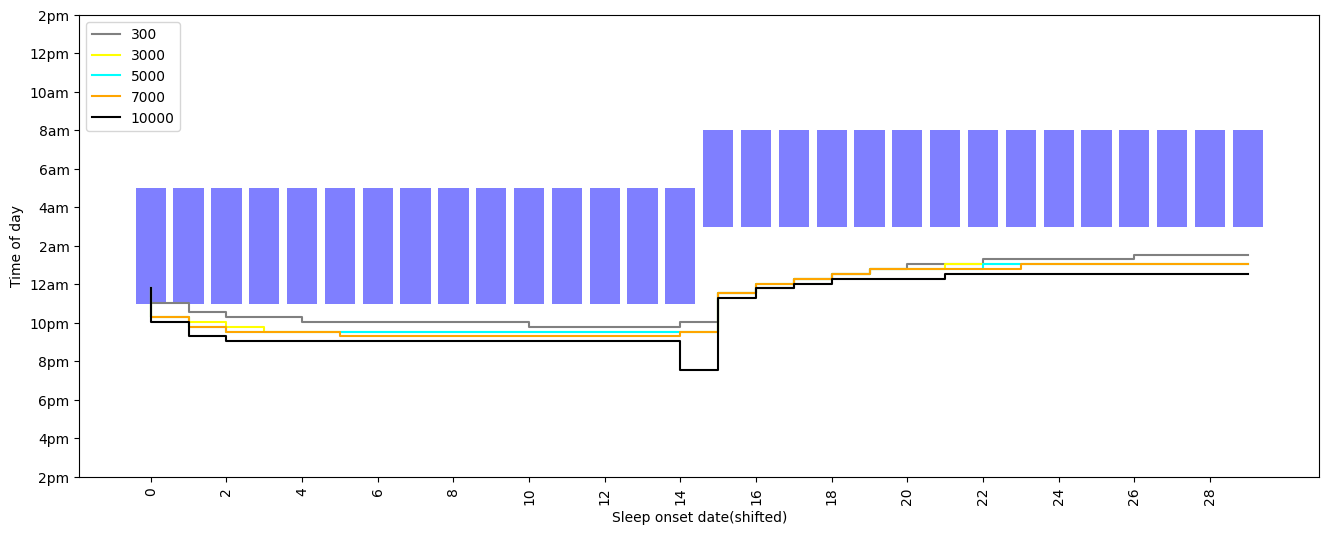

In [41]:
where_type = "pre"
fig,axs = plt.subplots(figsize=(16,6))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color="blue",alpha=0.5)


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
    

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
# plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")

# color_list = ['grey','yellow','cyan','orange', 'black']
k_list = [300,3000,5000,7000,10000]
k_colors = ['grey','yellow','cyan','orange', 'black']
for k, k_c in zip(k_list, k_colors):
    print(k,k_c)
    light_values, _df = ampval(k)
    EstimatedSleepOnset_SleepWake = run_model(light_values) #saving this in a new array

    axs.step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset_SleepWake, 
             color=k_c, where=where_type, label = k)
#     axs.grid(color='0.95')
axs.legend()
plt.savefig("/file/out/antar/ampwise_bigchange.png",dpi=400)
plt.show()